## Loading Data

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

TypeError: ignored

In [ ]:
import zipfile
import os

os.mkdir('/content/dataset')

path = '/content/deepglobe-road-extraction-dataset.zip'
dest = '/content/dataset'

with zipfile.ZipFile(path, 'r') as zip_ref:
  zip_ref.extractall(dest)
  print(f'{zip} is done extracting!')

<class 'zip'> is done extracting!


## Data Preprocessing

In [ ]:
import pandas as pd

path = '/content/dataset/'
path = os.path.join(path, 'metadata.csv')
df = pd.read_csv(path)

train = df[df['split'] == 'train']
train = train[['image_id', 'sat_image_path', 'mask_path']]

In [ ]:
new_path = '/content/dataset/'

train['sat_image_path'] = train['sat_image_path'].apply(lambda img_pth: os.path.join(new_path, img_pth))
train['mask_path'] = train['mask_path'].apply(lambda img_pth: os.path.join(new_path, img_pth))

train = train.sample(frac = 1).reset_index(drop = True)

In [ ]:
small_train = train.sample(1000).reset_index(drop=True)

In [ ]:
import numpy as np

images = np.zeros((1000, 256, 256, 3)).astype('float')
masks = np.zeros((1000, 256, 256, 1)).astype('float')

In [ ]:
import cv2
from tqdm import tqdm

data_length = len(small_train)
for i in tqdm(range(data_length)):
  img = cv2.imread(small_train['sat_image_path'][i])/255.
  mask = cv2.imread(small_train['mask_path'][i], cv2.IMREAD_GRAYSCALE)/255.
  img =  cv2.resize(img, (256, 256))
  mask = cv2.resize(mask, (256, 256))
  mask = mask.reshape(256, 256, 1)
  images[i] = img
  masks[i] = mask
  del img, mask

100%|██████████| 1000/1000 [00:38<00:00, 25.74it/s]


In [ ]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

## ResUnet Model

In [1]:
import tensorflow as tf
from tensorflow import keras

In [21]:
def batch_norm(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def convolutional(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batch_norm(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem_convolutional(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = convolutional(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = batch_norm(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = convolutional(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = convolutional(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = batch_norm(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsampling_concatenate(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [29]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem_convolutional(e0, f[0])
    e2 = residual(e1, f[1], strides=2)
    e3 = residual(e2, f[2], strides=2)
    e4 = residual(e3, f[3], strides=2)

    ## Bridge
    b0 = convolutional(e4, f[3], strides=1)
    b1 = convolutional(b0, f[3], strides=1)
    
    ## Decoder
    u1 = upsampling_concatenate(b1, e3)
    d1 = residual(u1, f[3])
    
    u2 = upsampling_concatenate(d1, e2)
    d2 = residual(u2, f[2])
    
    u3 = upsampling_concatenate(d2, e1)
    d3 = residual(u3, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d3)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
image_size = 256
epochs = 50

model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

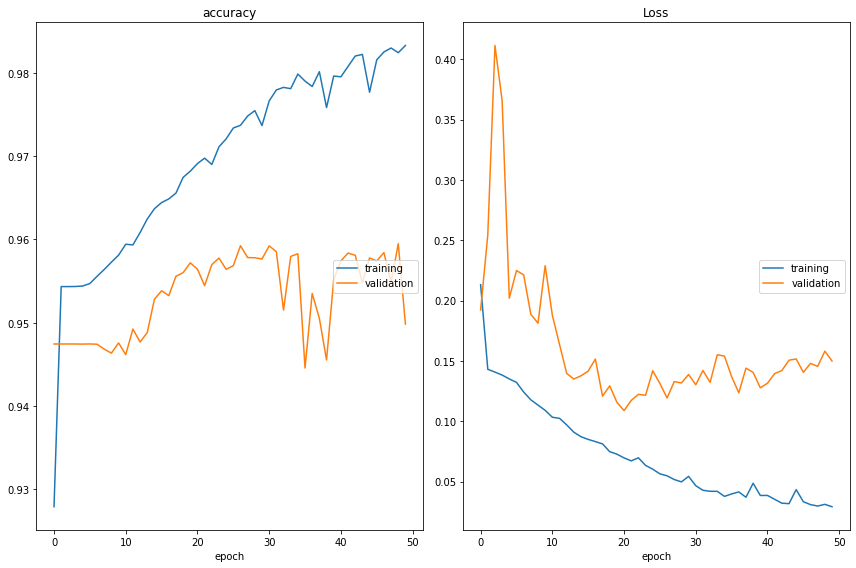

accuracy
	training         	 (min:    0.928, max:    0.983, cur:    0.983)
	validation       	 (min:    0.945, max:    0.960, cur:    0.950)
Loss
	training         	 (min:    0.029, max:    0.213, cur:    0.029)
	validation       	 (min:    0.109, max:    0.411, cur:    0.150)


In [ ]:
result = model.fit(images, masks, validation_split = 0.1, epochs = epochs, callbacks=[PlotLossesKeras()])

In [ ]:
predicted = model.predict(images)

Text(0.5, 1.0, 'predicted img')

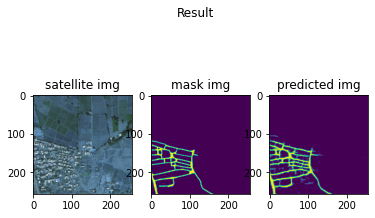

In [ ]:
from matplotlib import pyplot as plt

index = 29

a = images[index]
b = masks[index]
b = np.squeeze(b, axis = -1)
c = predicted[index]
c = np.squeeze(c, axis = -1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Result')
ax1.imshow(a)
ax1.set_title('satellite img')
ax2.imshow(b)
ax2.set_title('mask img')
ax3.imshow(c)
ax3.set_title('predicted img')

In [ ]:
model.save('/content/resunet_500d100e.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
